In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import pretreat_data
import seaborn as sns
sns.set_style("darkgrid")
colors = sns.color_palette("colorblind6")

# Path to the data
train_path = "../data/ClimateTrain.csv"
test_path = "../data/ClimateTest.csv"

# Read as pandas dataframe and transform dates to datetime
train_df = pd.read_csv(train_path)
train_df['date'] = pd.to_datetime(train_df['date'])

test_df = pd.read_csv(test_path)
test_df['date'] = pd.to_datetime(test_df['date'])

# Plot description
train_df.describe()
test_df.describe()

,date,meantemp,humidity,wind_speed,meanpressure
count,114,114.000000,114.000000,114.000000,114.000000
mean,2017-02-26 12:00:00,21.713079,56.258362,8.143924,1004.035090
min,2017-01-01 00:00:00,11.000000,17.750000,1.387500,59.000000
25%,2017-01-29 06:00:00,16.437198,39.625000,5.563542,1007.437500
50%,2017-02-26 12:00:00,19.875000,57.750000,8.069444,1012.739316
75%,2017-03-26 18:00:00,27.705357,71.902778,10.068750,1016.739583
max,2017-04-24 00:00:00,34.500000,95.833333,19.314286,1022.809524
std,NaN,6.360072,19.068083,3.588049,89.474692


## Pretreat the data

In [71]:
train_df, test_df, reference_stats = pretreat_data(train_df, test_df)

Pre-treating data...


## Plot to double check that data looks okay

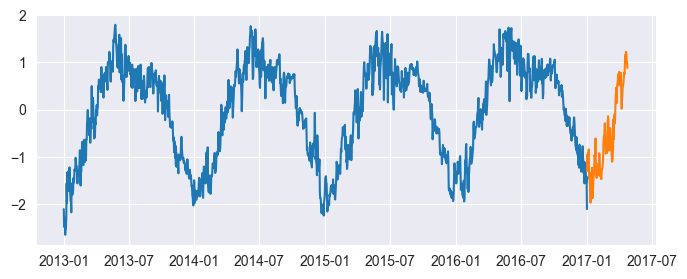

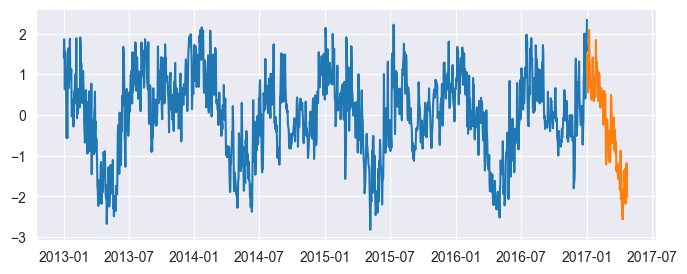

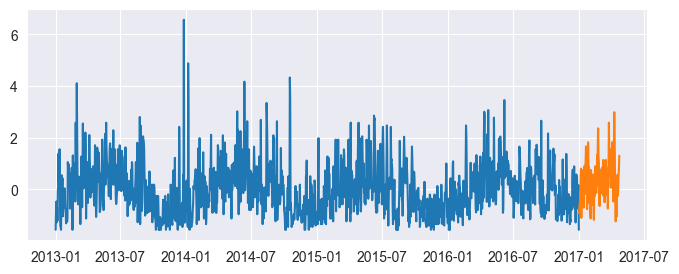

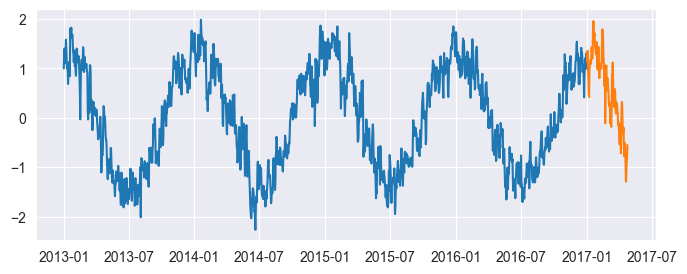

In [72]:
for col in train_df.columns[1:]:
    plt.figure(figsize=(8,3))
    plt.plot(train_df["date"], train_df[col])
    plt.plot(test_df["date"], test_df[col])
    

# Metrics

In [73]:
def RMSE(gt, pred):
    return np.sqrt(((pred - gt)**2).mean())

def SMAPE(gt, pred):
    return ( (np.abs(pred - gt)) / ((np.abs(gt) + np.abs(pred))/2) ).mean()
    

# 1.0 Baseline mode

RMSE:  0.7183307931448861
SMAPE:  0.8021567025749691


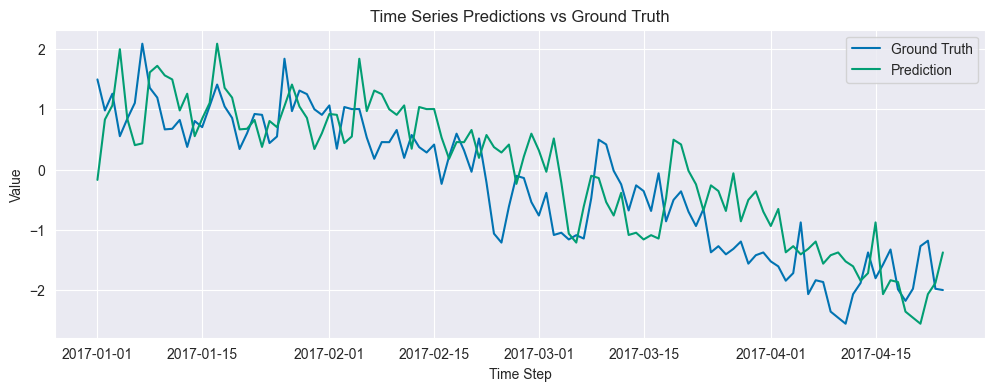

In [74]:
horizon = 10
test_start_date = test_df["date"].loc[0]
test_window_date = test_start_date - pd.Timedelta(days=horizon)
filtered_train_df = train_df[(train_df['date'] >= test_window_date) & (train_df['date'] < test_start_date)]
test_df_altered = pd.concat([filtered_train_df, test_df], ignore_index=True)

pred = []
gt = []
for i in range(len(test_df_altered)-horizon):
    pred.append(test_df_altered["humidity"].iloc[i])
    gt.append(test_df_altered["humidity"].iloc[i+horizon])

# Squeeze the extra dimensions away and turn to numpy
gt = np.array(gt)
pred = np.array(pred)

# Check that metrics give zero
# gt = gt[:-horizon]
# pred = pred[horizon:]

mean_rmse = RMSE(gt, pred)
mean_smape = SMAPE(gt, pred)
print("RMSE: ", mean_rmse)
print("SMAPE: ", mean_smape)

plt.figure(figsize=(12,4))
plt.plot(test_df["date"], gt, label="Ground Truth", color=colors[0])
plt.plot(test_df["date"], pred, label="Prediction", color=colors[1])

# Add labels, legend, and grid
plt.title("Time Series Predictions vs Ground Truth")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid("on")

plt.show()

# 1.1 RNN, LSTM, and Transformer models

In [99]:
from utils import rolling_train_valid_split
from dataset import TimeSeriesDataset
from torch import nn, optim
from torch.utils.data import DataLoader
import torch

torch.manual_seed(42)
# use importlib magic so that if changes is made in the models, no need to restart the jupyter notebook
from importlib import reload
import models
import trainer
import transformer_model
reload(models)
reload(trainer)
reload(transformer_model)

from trainer import train, validate
from transformer_model import TransformerForecaster, DecoderForecaster
from models import RNN_model, LSTM_model

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# number of points
window_size = 30
hidden_size = 128
embed_dim = 128
n_layers = 2
output_size = 1

date_as_var = True
if date_as_var:
    input_size = 6
else:
    input_size = 4

# Define model
model_type = "RNN"
match model_type:
    case "RNN":
        model = RNN_model(hidden_size=hidden_size, embed_dim = embed_dim, n_layers=n_layers, input_size=input_size, out_features=output_size, dropout_p=0.2)
    case "LSTM":
        model = LSTM_model(hidden_size=hidden_size, embed_dim = embed_dim, n_layers=n_layers, input_size=input_size, out_features=output_size, dropout_p=0.2)
    case "Transformer":
        model = model = TransformerForecaster(hidden_size=hidden_size, embed_dim = embed_dim, 
                              encoder_heads=4, encoder_depth=4,
                              decoder_heads=4, decoder_depth=4, 
                              input_size=input_size, out_features=output_size, dropout_p=0.2)
    case "Decoder":
        model = DecoderForecaster(hidden_size=hidden_size, embed_dim = embed_dim, 
                        decoder_heads=2, decoder_depth=1, 
                        input_size=input_size, out_features=output_size, dropout_p=0.2)
    case _:
             "Something's wrong with the internet"

model = model.to(device)

# Define batch size
batch_size = 2048
n_epochs = 100
lr = 0.001

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr)

# Set Horizon
horizon = 1

## 1.1 Train

In [100]:
# Generate rolling train-validation splits
loss_history = {0: {"train": [], "valid": []}, 
                1: {"train": [], "valid": []}, 
                2: {"train": [], "valid": []},
                3: {"train": []}}
for i, (train_data, valid_data) in enumerate(rolling_train_valid_split(train_df, months=6, window_size=window_size, horizon=horizon)):
    print("Training fold ", i)
    train_dataset = TimeSeriesDataset(df=train_data, window_size=window_size, horizon=horizon, date_as_var=date_as_var)
    if valid_data is not None:
        valid_dataset = TimeSeriesDataset(df=valid_data, window_size=window_size, horizon=horizon, date_as_var=date_as_var)
    
    # Initialize the dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

    avg_val_loss = 0
    for epoch in range(n_epochs):
        avg_train_loss = train(model, train_loader, criterion, optimizer, device, model_type)
        
        loss_history[i]["train"].append(avg_train_loss)
        
        if valid_data is not None:
            avg_val_loss = validate(model, valid_loader, criterion, device, model_type)
            loss_history[i]["valid"].append(avg_val_loss)
        print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    

Training fold  0
Epoch 1/100, Train Loss: 1.1868, Val Loss: 0.7076
Epoch 2/100, Train Loss: 0.6781, Val Loss: 0.3707
Epoch 3/100, Train Loss: 0.4648, Val Loss: 0.3703
Epoch 4/100, Train Loss: 0.4900, Val Loss: 0.4277
Epoch 5/100, Train Loss: 0.4934, Val Loss: 0.4339
Epoch 6/100, Train Loss: 0.4392, Val Loss: 0.4161
Epoch 7/100, Train Loss: 0.3973, Val Loss: 0.4054
Epoch 8/100, Train Loss: 0.4198, Val Loss: 0.4080
Epoch 9/100, Train Loss: 0.4266, Val Loss: 0.4103
Epoch 10/100, Train Loss: 0.4409, Val Loss: 0.4053
Epoch 11/100, Train Loss: 0.4143, Val Loss: 0.3915
Epoch 12/100, Train Loss: 0.4029, Val Loss: 0.3759
Epoch 13/100, Train Loss: 0.3813, Val Loss: 0.3680
Epoch 14/100, Train Loss: 0.3547, Val Loss: 0.3714
Epoch 15/100, Train Loss: 0.3667, Val Loss: 0.3835
Epoch 16/100, Train Loss: 0.3742, Val Loss: 0.3946
Epoch 17/100, Train Loss: 0.3791, Val Loss: 0.3958
Epoch 18/100, Train Loss: 0.3747, Val Loss: 0.3863
Epoch 19/100, Train Loss: 0.3750, Val Loss: 0.3704
Epoch 20/100, Train Los

## Plot train and validation losses

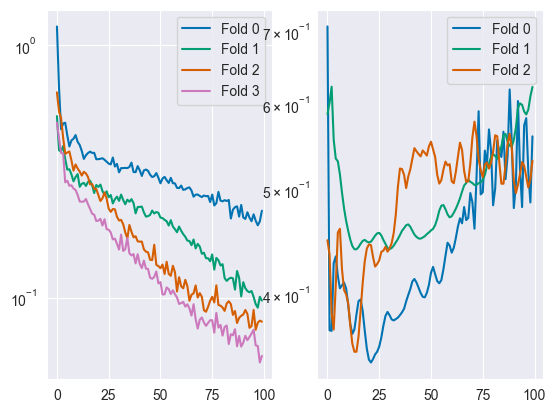

In [101]:
fig, ax = plt.subplots(1,2)
for i in range(4):
    ax[0].plot(loss_history[i]["train"], label=f"Fold {i}", color=colors[i])
    ax[0].legend()
    if "valid" in loss_history[i]:
        ax[1].plot(loss_history[i]["valid"], label=f"Fold {i}", color=colors[i])
        ax[1].legend()
    ax[0].semilogy()
    ax[1].semilogy()

## 1.2 Test

In [102]:
# Add The required windows size to the test df so that we can start predicting from the beginning
test_horizon = 1
test_start_date = test_df["date"].loc[0]
test_window_date = test_start_date - pd.Timedelta(days=window_size+test_horizon)
filtered_train_df = train_df[(train_df['date'] >= test_window_date) & (train_df['date'] < test_start_date)]
test_df_altered = pd.concat([filtered_train_df, test_df], ignore_index=True)

test_dataset = TimeSeriesDataset(df=test_df_altered, window_size=window_size, horizon=test_horizon, date_as_var=date_as_var)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

len(test_dataset)
print("first target", test_dataset[0][1])
print(f"{window_size+test_horizon}th window humidity", test_dataset[window_size+test_horizon][0][0] )

first target tensor(1.4961)
31th window humidity tensor([-1.3041,  1.4961, -0.9173,  1.1432,  0.0172,  0.9999])


In [103]:
model.eval()
total_rmse, total_smape = 0, 0
results = {"pred": [], "gt": []}
with torch.no_grad(): # Iterate
    for idx in range(len(test_dataset)):
        inputs, targets = test_dataset[idx]
        inputs, targets = inputs.unsqueeze(0).to(device), targets.to(device)
        if model_type == "RNN" or model_type == "LSTM":
            # Initialize the hidden state
            prev_state = model.init_state(inputs.size(0), device)
        
            # Pass the input through the model
            outputs, _ = model(inputs, prev_state)
        else:
            # Shift the targets to the right so the input and the correct target match
            input = inputs[:, :-1, :]
            target = inputs[:, 1:, :]
            outputs = model(input, target)

        # Squeeze away the extra dimensions
        outputs = outputs.squeeze()
        targets = targets.squeeze()
        
        results["gt"].append(targets.cpu())
        results["pred"].append(outputs.cpu())
    

# Squeeze the extra dimensions away and turn to numpy
gt = np.array(results["gt"])
pred = np.array(results["pred"])

mean_rmse = RMSE(gt, pred)
mean_smape = SMAPE(gt, pred)
print("RMSE: ", mean_rmse)
print("SMAPE: ", mean_smape)


RMSE:  0.6491078
SMAPE:  0.8474979


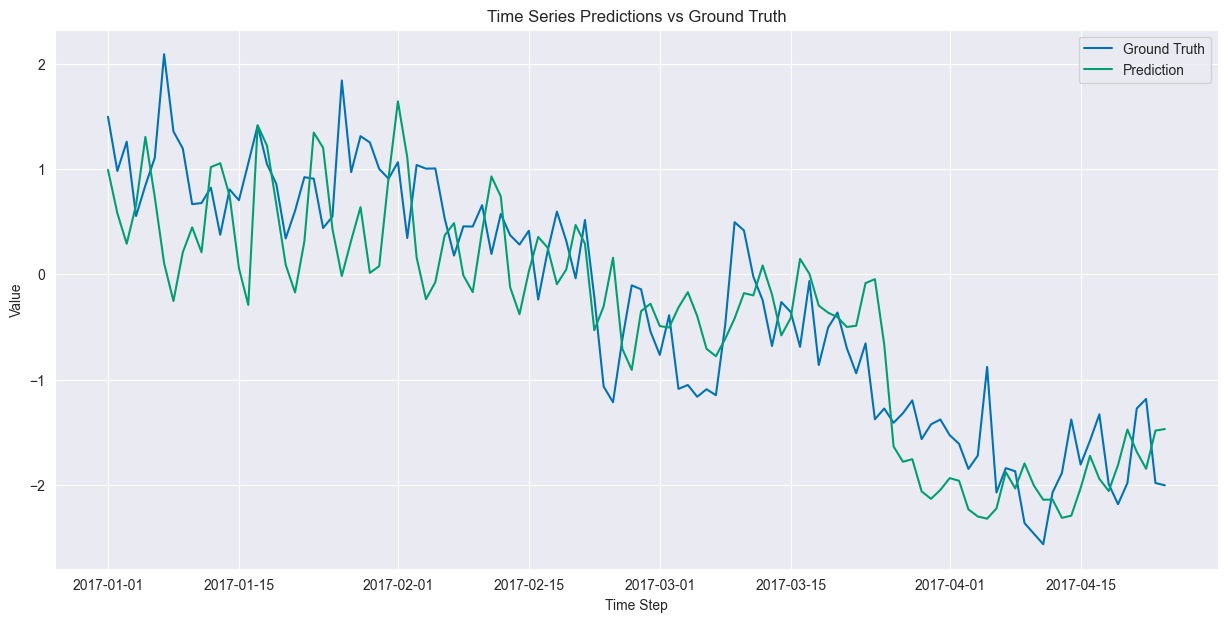

In [104]:

# Plot the ground truth and predictions
plt.figure(figsize=(15, 7))
plt.plot(test_df["date"], gt, label="Ground Truth", color=colors[0])
plt.plot(test_df["date"], pred, label="Prediction", color=colors[1])

# Add labels, legend, and grid
plt.title("Time Series Predictions vs Ground Truth")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid("on")

plt.show()

# plt.plot(results["gt"])
# plt.plot(results["pred"])